# Week 1 Exercises -- BEEM012.

Adapted from exercises and examples in Hanck, Arnold, Gerber, and Schmelzer (2020) 

Introduction to Econometrics with R. Accessible here. This book is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License. (HA)

# Section 1: Manipulating Time Series Data

## Section 1.1

In [2]:
# Install the following packages: 
# (Once you have installed these, you can comment out these lines)
#install.packages("readxl")
#install.packages("AER")
#install.packages("xts")
#install.packages("dynlm")

# Load useful libraries we will use for time series.
library(AER)
library(readxl)
library(xts)
library(zoo)
library(dynlm)

## Section 1.2: Load & Format Data

In [3]:
# load UK macroeconomic data
UK_gdp <- read_excel(path = "UK_GDPpc_Quarterly-Full.xls")

In [4]:
# Now, we want to reformat our data so that the "Date" column
# is loaded in as a recognized date. To understand the format string
# format = "%Y Q%q" load the raw xls file and look at how dates are stored
# in that file.
UK_gdp$Date <- as.yearqtr(UK_gdp$Date, format = "%Y Q%q")

In [5]:
# We're going to convert our data into an xts formatted object, so we can use
# time series tools easily:
GDP_full_xts <- xts(UK_gdp$GDPpc, UK_gdp$Date)

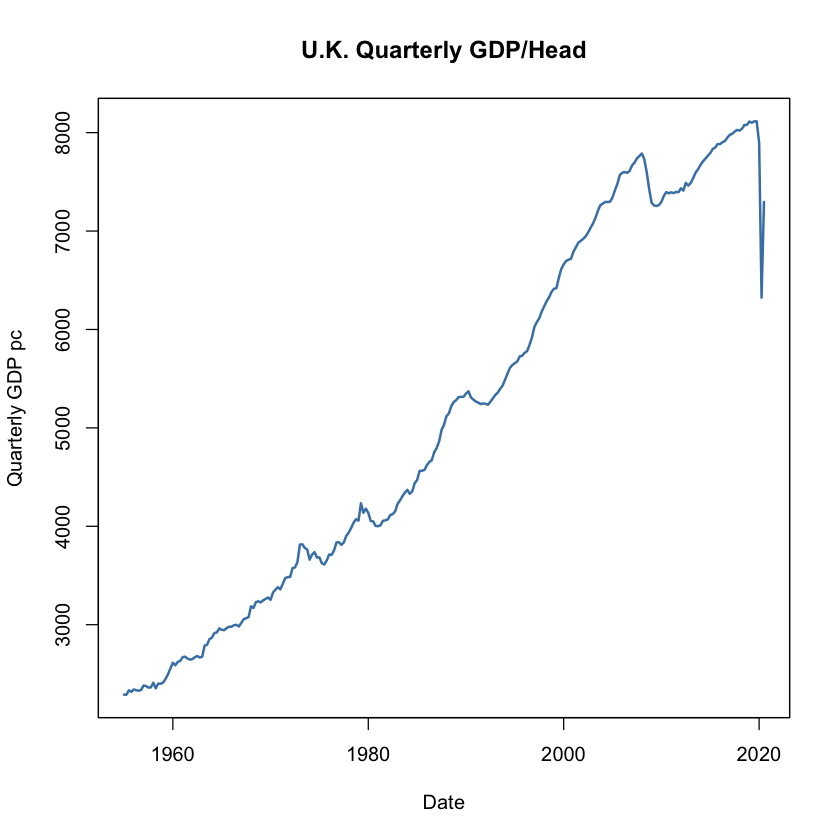

In [6]:
# Let's plot some of this data to get a sense of the patterns that exist:
plot(as.zoo(GDP_full_xts),col = "steelblue",
     lwd = 2,
     ylab = "Quarterly GDP pc",
     xlab = "Date",
     main = "U.K. Quarterly GDP/Head")

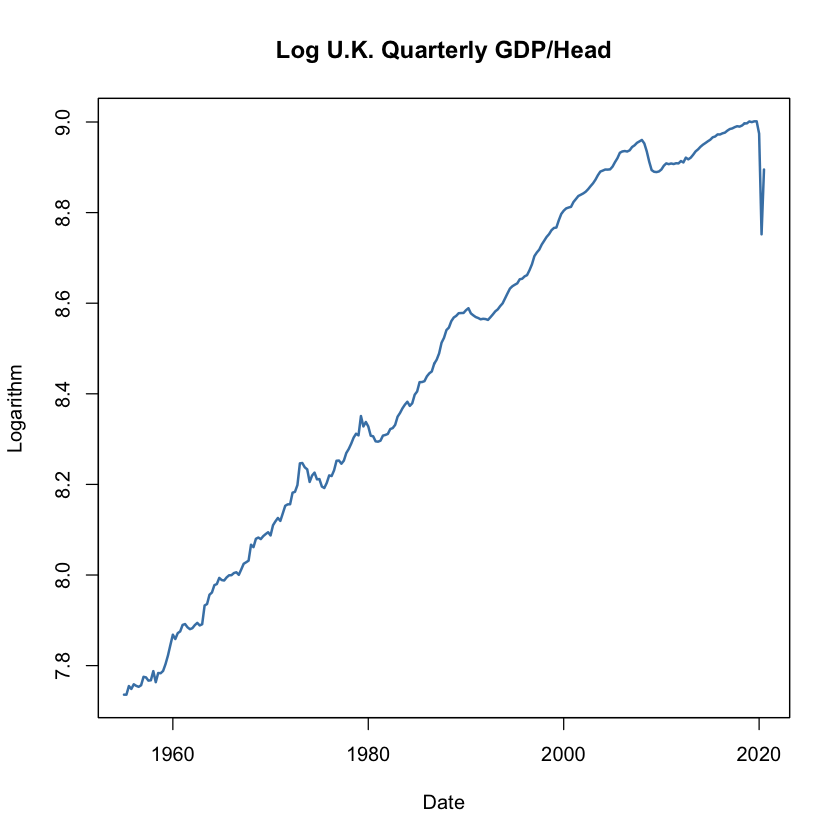

In [7]:
plot(as.zoo(log(GDP_full_xts)),col = "steelblue",
     lwd = 2,
     ylab = "Logarithm",
     xlab = "Date",
     main = "Log U.K. Quarterly GDP/Head")

In [8]:
# We're also going to learn how to take subsets of our data. 
# It looks like we've got huge outliers in 2020-2021 (obviously!) so we are going to look at data up to 2019 instead.
# We can remove this outlier if it's convenient to do so like this when it is near the end of our time series,
# or we could include it and just take account of it when doing our analysis.
GDP_xts = GDP_full_xts["1960::2019"]

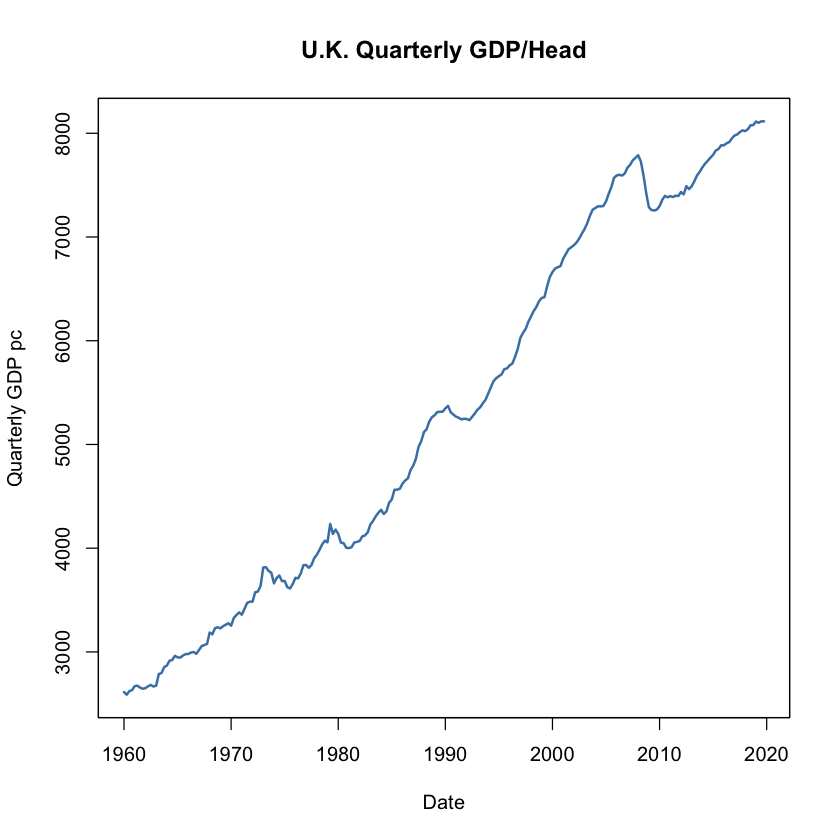

In [9]:
# Let's plot some of this data to get a sense of the patterns that exist:
plot(as.zoo(GDP_xts),col = "steelblue",
     lwd = 2,
     ylab = "Quarterly GDP pc",
     xlab = "Date",
     main = "U.K. Quarterly GDP/Head")

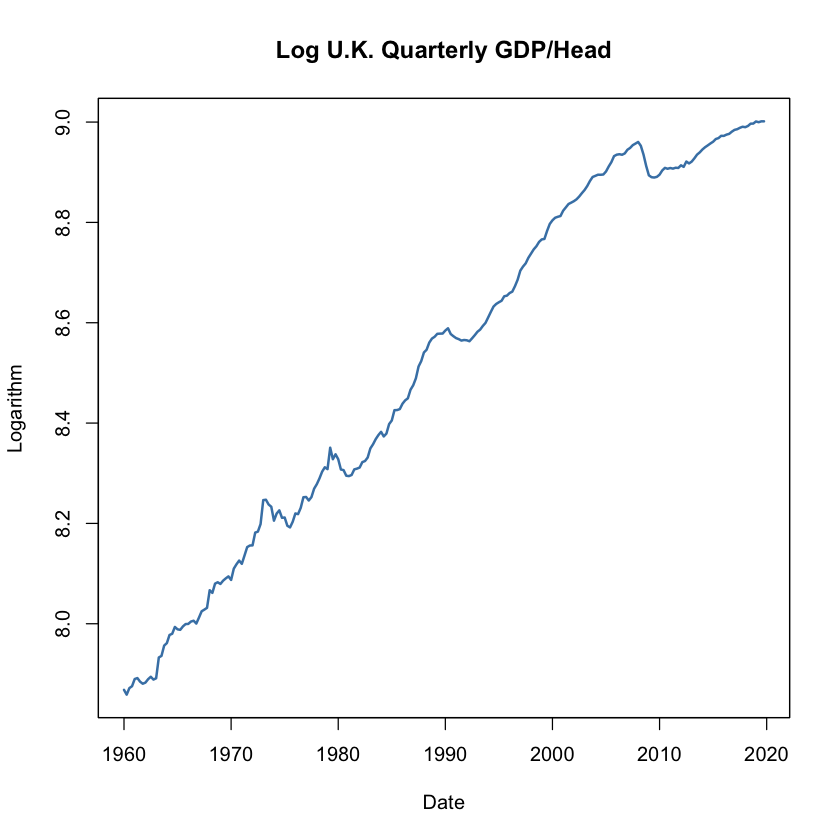

In [10]:
plot(as.zoo(log(GDP_xts)),col = "steelblue",
     lwd = 2,
     ylab = "Logarithm",
     xlab = "Date",
     main = "Log U.K. Quarterly GDP/Head")

## Section 1.3: Lags and Differences

In [11]:
 
# # Lags are very important for understanding time series.
# Uncomment the line below to explore the details of the lag() operator
# we use for time series data:
# ?lag

In [12]:
# To take the lag of a variable, we use the lag() operator, where the second 
# argument is the order of the lag:
GDP_xts_lag2 = lag(GDP_xts,2)
# Here we are taking the 2nd-order lag of Y_t. 
# When you look at the first few periods, what do you notice about missing values?
print(GDP_xts_lag2["1960::1961"])

        [,1]
1960 Q1   NA
1960 Q2   NA
1960 Q3 2613
1960 Q4 2588
1961 Q1 2622
1961 Q2 2632
1961 Q3 2670
1961 Q4 2675


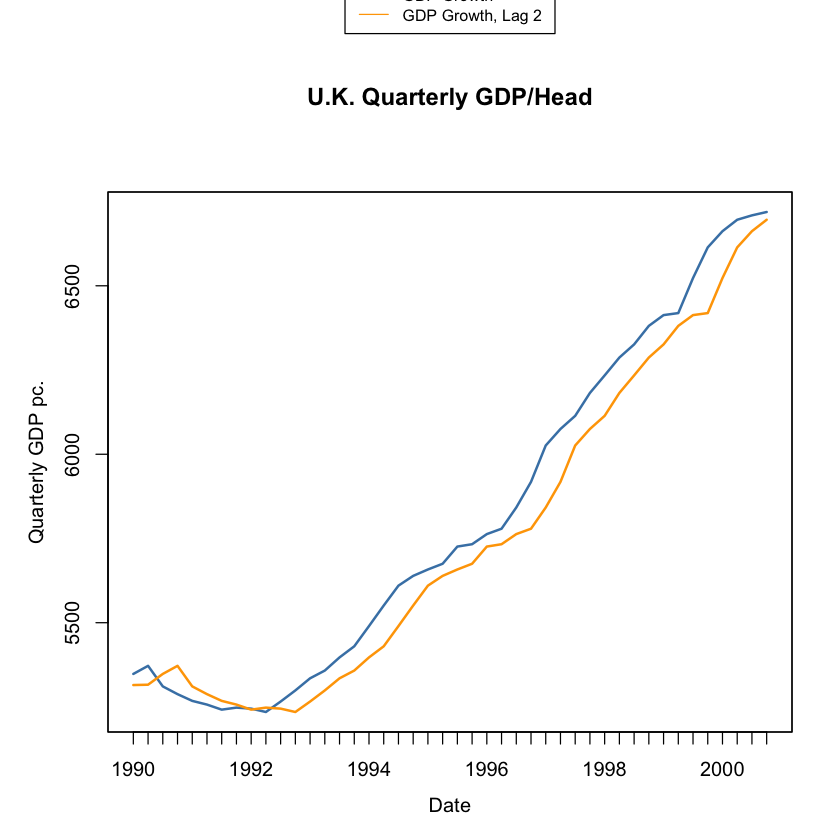

In [13]:
# Let's plot these lags to make sure we know what is going on:
par(mar=c(4.5, 4.5, 8, 2), xpd=TRUE)
plot(as.zoo(GDP_xts["1990::2000"]), col = "steelblue",
     lwd = 2,
     ylab = "Quarterly GDP pc.",
     xlab = "Date",
     mgp = c(2.5, 1, 0),
     mar= c(3,3,3,3), 
     width=5,
     height=5,
     main = "U.K. Quarterly GDP/Head")
lines(as.zoo(GDP_xts_lag2["1990::2000"]),
      type = "l", lwd =2,
      col = "orange")
legend("top",
       c("GDP Growth", "GDP Growth, Lag 2"), 
       col = c("steelblue", "orange"), 
       lty = c(1, 1),
       inset=c(0,-0.4),
       cex = 0.8
)

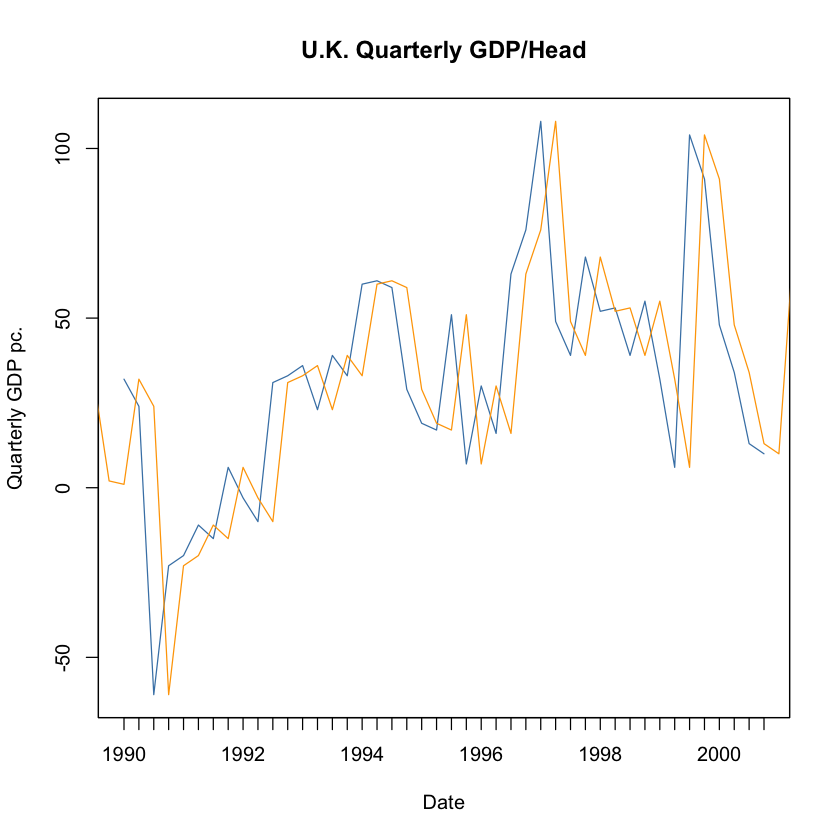

In [14]:
# In addition to lags, we are also interested in differences:
GDP_diff_xts <- diff(GDP_xts)
# We can also take lags of differences:
GDP_diff_lag1_xts <- lag(GDP_diff_xts,1)

plot(as.zoo(GDP_diff_xts["1990::2000"]), col = "steelblue",
     lwd = 1,
     ylab = "Quarterly GDP pc.",
     xlab = "Date",
     main = "U.K. Quarterly GDP/Head")
lines(as.zoo(GDP_diff_lag1_xts),
      type = "l", lwd =1,
      col = "orange")
legend("top",
       c("GDP First Difference", "GDP First Difference, Lag 2"), 
       col = c("steelblue", "orange"), 
       lty = c(1, 1),
       inset=c(0,-0.4),
       cex = 0.8
)

In [15]:
# We might also want to think of the Growth rate, which is useful for analysis and interpretation.
GDPGrowth_xts <- xts(400 * log(GDP_xts/lag(GDP_xts)))

## Section 2.1: Autocovariance & Autocorrelation:

In [16]:

# let's take a subset of the data to work with and generate the lags of 
GDP_1990_2005 <- GDP_xts["1990::2005"]

GDPGR_1990_2005 <- GDPGrowth_xts["1990::2005"]
GDPGR_1990_2005_lag1 <- lag(GDPGR_1990_2005)

# We drop the periods where we cannot observe GDP growth lags.
# take a look at the dataframe with our computed growth rates and lags,
# Where do we have missing values?
print(GDPGR_1990_2005_lag1["1990::1991"])

                 x
1990 Q1         NA
1990 Q2  2.4006074
1990 Q3  1.7910478
1990 Q4 -4.5680549
1991 Q1 -1.7360156
1991 Q2 -1.5157275
1991 Q3 -0.8361048
1991 Q4 -1.1429668


In [17]:
# We can't compute the lag in the first period (1990 Q1), because we need 
# to observe the prior period.
# So, we fix this by dropping the first observation of each.
# Now we compute the sample covariance and variance:
autocov_1 = cov(GDPGR_1990_2005[-1], GDPGR_1990_2005_lag1[-1])
var_yt = var(GDPGR_1990_2005[-1])
# With these two values, use Equation 1 from the exercise handout to compute the 
# the sample estimate of first-order autocorrelation:
autocor_yt_lag1 = autocov_1 / var_yt
print(autocor_yt_lag1)

          x
x 0.5647888


In [18]:
# Now, use the 'acf' function to compute the first four autocorrelations in one step:

# Compute these autocorrelations for 1965-1990:

# Compute these autocorrelations for 2005-2020:

# Section 3: Autoregressions

## Section 3.1: Data Setup

In [19]:
# Let's set up data and lags manually so we can run an autoregression.
# length of data set

In [20]:
N <-length(GDPGR_1990_2005)
# So to manually create lags, we drop the first observation of our Y_t,
# which has the effect of ''shifting'' all observations by one. 
# To ensure we keep the same number of observations, we drop the final
# observation of the time series to get our series of lags

## IF THIS SEEMS CONFUSING, DON'T WORRY! In practice you will always use 
# the lag() function to compute lags, but I thought it would be good to
# demonstrate how we can do this without any special functions.

# Recall: using the [-N] index removes the Nth item from the array
GDPGR_level <- as.numeric(GDPGR_1990_2005[-1])
# Now drop the last value to get a series of lags
GDPGR_lags <- as.numeric(GDPGR_1990_2005[-N])
# estimate the linear model
armod <- lm(GDPGR_level ~ GDPGR_lags)
coeftest(armod)

# We can use the lag() operator to do this in one step:
# This is the same as lm(Y_t ~ Y_(t-1))
GDPGR_AR1_lm <- lm(GDPGR_1990_2005 ~ lag(GDPGR_1990_2005,1))
coeftest(GDPGR_AR1_lm)
summary(GDPGR_AR1_lm)$r.squared


t test of coefficients:

            Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  0.94948    0.31418  3.0221  0.003667 ** 
GDPGR_lags   0.57972    0.10638  5.4494 9.615e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



t test of coefficients:

                        Estimate Std. Error t value  Pr(>|t|)    
(Intercept)              0.94948    0.31418  3.0221  0.003667 ** 
lag(GDPGR_1990_2005, 1)  0.57972    0.10638  5.4494 9.615e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


[1] 0.3274207

In [21]:
# Using the lag notation above, compute the 2nd and 3rd order AR models:
# This is the same as lm(Y_t ~ Y_(t-1) + Y_(t-2)) which is equivalent
# to estimating Y_t = \beta_0 + \beta_1 Y_(t-1) + \beta_2 Y_(t-2)
GDPGR_AR2_lm <- lm(GDPGR_1990_2005 ~ lag(GDPGR_1990_2005,1) + lag(GDPGR_1990_2005,2))
coeftest(GDPGR_AR2_lm)
summary(GDPGR_AR2_lm)$r.squared

GDPGR_AR2_lm <- lm(GDPGR_1990_2005 ~ lag(GDPGR_1990_2005,1:2))
coeftest(GDPGR_AR2_lm)
summary(GDPGR_AR2_lm)$r.squared

# Now, we can compute this with a single step without even having to write out
# the individual lags using the ar.ols() module:
arpackage_model <- ar.ols(GDPGR_1990_2005, 
                          demean = FALSE,
                          aic = FALSE,
                          order.max = 3,
                          intercept = TRUE)
print(arpackage_model)
arpackage_model_coef = as.numeric(arpackage_model$ar[1])
arpackage_model_coef_se = as.numeric(arpackage_model$asy.se.coef$ar[2])
arpackage_model_coef_tstat = arpackage_model_coef / arpackage_model_coef_se
print(arpackage_model_coef_tstat)


t test of coefficients:

                        Estimate Std. Error t value  Pr(>|t|)    
(Intercept)             0.934044   0.342263  2.7290  0.008358 ** 
lag(GDPGR_1990_2005, 1) 0.565984   0.131301  4.3106 6.267e-05 ***
lag(GDPGR_1990_2005, 2) 0.025168   0.131749  0.1910  0.849156    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


[1] 0.3285654


t test of coefficients:

                             Estimate Std. Error t value  Pr(>|t|)    
(Intercept)                  0.934044   0.342263  2.7290  0.008358 ** 
lag(GDPGR_1990_2005, 1:2)x   0.565984   0.131301  4.3106 6.267e-05 ***
lag(GDPGR_1990_2005, 1:2)x.1 0.025168   0.131749  0.1910  0.849156    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


[1] 0.3285654


Call:
ar.ols(x = GDPGR_1990_2005, aic = FALSE, order.max = 3, demean = FALSE,     intercept = TRUE)

Coefficients:
      1        2        3  
 0.5463   0.0666  -0.0419  

Intercept: 1.085 (0.3089) 

Order selected 3  sigma^2 estimated as  2.13
[1] 4.267764


# Section 4: Forecasting & Forecast Error

In [23]:
# the terms in the square brackets in GDPGrowth_xts["2005"][4] are used to 
# select a particular observation - here we are choosing Q4 of 2005.
# Recall that with AR1 model the forecast of Y_t is:
# Y_t = \beta_0_AR1 + \beta_1_AR1 * Y_(t-1)
# Here, to forecast we want to predict the first observation outside of our data
# used to estimate the model, which ends in 2005, Q4. So here, T+1 = 2006 Q1,
# so we use the observed Y_T from 2005 Q4 and the estimated coefficients to 
# forecast:
beta_0_AR1 <- coef(GDPGR_AR1_lm)[1]
beta_1_AR1 <- coef(GDPGR_AR1_lm)[2]
forecasted_value_AR1 = beta_0_AR1 + (beta_1_AR1 %*% GDPGrowth_xts["2005"][4])
# Now, let's see how accurate this is:
forecast_error_AR1 = forecasted_value_AR1 - GDPGrowth_xts["2006"][1]
cat("Forecasted Value AR(1):", forecasted_value_AR1, "\n")
cat("Actual Value AR(1):", GDPGrowth_xts["2006"][1], "\n")
cat("Forecast Error AR(1):", forecast_error_AR1, "\n")

Forecasted Value AR(1): 3.722567 
Actual Value AR(1): 1.160644 
Forecast Error AR(1): 2.561922 


In [24]:
# With AR2, the forecast of Y_t is:
# With AR3, the forecast of Y_t is:
### 
GDPGrowth_xts <- xts(400 * log(GDP_xts/lag(GDP_xts)))
GDPGR_1990_2005 <- GDPGrowth_xts["1990::2005"]

# Now, add the unemployment rate:
UK_UnemploymentRate <- read_excel(path = "UK_UnemploymentRate.xls")
UK_UnemploymentRate$Date <- as.yearqtr(UK_UnemploymentRate$Date, format = "%Y Q%q")
UK_UnemploymentRate_xts <- xts(UK_UnemploymentRate$UnemploymentRate, UK_UnemploymentRate$Date)
UK_UnemploymentRate_1990_2005 <- UK_UnemploymentRate_xts["1990::2005"]
UK_UnemploymentRate_diff = diff(UK_UnemploymentRate_1990_2005)

In [25]:
# Take the code above to estimate the ADL11 model:
GDPGR_ADL11_lm_unemp <- lm(GDPGR_1990_2005 ~ lag(GDPGR_1990_2005,1) + lag(UK_UnemploymentRate_diff,1))
coeftest(GDPGR_ADL11_lm_unemp)
summary(GDPGR_ADL11_lm_unemp)$r.squared

# Take the code above to estimate the ADL22 model:
GDPGR_ADL22_lm_unemp <- lm(GDPGR_1990_2005 ~ lag(GDPGR_1990_2005,1) + lag(GDPGR_1990_2005,2) + lag(UK_UnemploymentRate_diff,1) + lag(UK_UnemploymentRate_diff,2))
coeftest(GDPGR_ADL22_lm_unemp)
summary(GDPGR_ADL22_lm_unemp)$r.squared


t test of coefficients:

                                 Estimate Std. Error t value  Pr(>|t|)    
(Intercept)                       1.15683    0.33201  3.4844 0.0009367 ***
lag(GDPGR_1990_2005, 1)           0.45658    0.12666  3.6048 0.0006432 ***
lag(UK_UnemploymentRate_diff, 1) -1.92120    1.09229 -1.7589 0.0837831 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


[1] 0.3616233


t test of coefficients:

                                  Estimate Std. Error t value  Pr(>|t|)    
(Intercept)                       1.306373   0.337837  3.8669 0.0002894 ***
lag(GDPGR_1990_2005, 1)           0.468669   0.120541  3.8881 0.0002703 ***
lag(GDPGR_1990_2005, 2)          -0.029964   0.126002 -0.2378 0.8128972    
lag(UK_UnemploymentRate_diff, 1) -2.181590   1.118126 -1.9511 0.0560532 .  
lag(UK_UnemploymentRate_diff, 2)  0.397549   1.070266  0.3714 0.7117048    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


[1] 0.4286366